# From boosted trees to a single tree

## Introduction

A simple decision tree is often considered to be the easiest model to understand, which is often important when the commissioner of a model is cautious and needs reassuring before a model can be deployed, or for where the regulatory framework demands that you are able to explain why a given prediction was made. However, newer approaches such as boosted trees, random forests and even neural networks often have much improved predictive power. These techniques are not as "black box" as often claimed and it is possible to understand what features are contributing the model, but this might not always be good enough.

Here the approach of Domingos<sup>[1]</sup> (_Knowledge acquisition from examples via multiple models_) is explored which allows a simple model to be built on top of a more complex model. This would allow, for example, a decision tree to be built on the results from a gradient boosted decision tree. The idea being that this decision tree is much more accurate than a decision tree trained on only the real data and is arguably more interpretible than the boosted tree itself.

In short a complex model is trained and used as an *oracle* that generates additional data to train the simplier model on, leading to the simplier model becoming more accurate (it is often said that more data beats better algorithms).

Related ideas (see, for example, _Do Deep Nets Really Need to be Deep?_ by Ba and Caruana<sup>[2]</sup>) are being used to train shallow neural networks from deep neural networks. These shallow neural networks are then able to have predictive power similar to the deep networks; more predictive power than they could achieve from training on the data alone. The motivation being that these shallow networks are more parallelisable, so are quicker at making predictions when deployed.
 
[1]:http://homes.cs.washington.edu/~pedrod/papers/mlc97.pdf
[2]:https://arxiv.org/abs/1312.6184

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generating example data
from sklearn.datasets import make_circles
from sklearn.datasets import load_digits

# Evaluation
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Classifiers used
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Visualising the decision trees
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz

# Use warnings so that a numpy deprecation error is only shown once
# Only needed for certain numpy/sklearn version combinations
import warnings
warnings.filterwarnings('default', category=DeprecationWarning)

## Demonstration of the basic principle

Let's start by creating a dataset to classify which contains just two classes. The aim is to create a noisy dataset so that the classifier has to work hard to separate them.

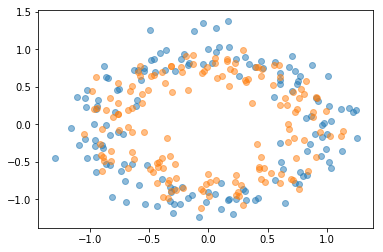

In [2]:
X, y = make_circles(n_samples=300, shuffle=True, noise=0.15, random_state=40)

plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.5)
plt.show()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40 )

For choosing the hyperparameters of the model I will be using cross-validation. Let's define two parameter grids for used in cross-validation (one for simple decision tree models and one for complex gradient boosted decision trees) that will be used throughout this notebook.

In [3]:
params_simp = {"max_depth": xrange(3, 10)}
params_comp = {"max_depth": xrange(3, 10), "n_estimators": xrange(50, 300, 50)}

A simple model can be fitted to the data and the model evaluated on the test data. Decision trees are ideal here as they are easy to interpret and can produce non-linear decision boundaries.

In [4]:
model_simp = DecisionTreeClassifier(random_state=40)
grid_simp = GridSearchCV(model_simp, cv=3, refit=True, param_grid=params_simp)

grid_simp.fit(X_train, y_train)
print "CV best parameters:", grid_simp.best_params_, "\n\n\n"

print classification_report(y_test, grid_simp.predict(X_test))

CV best parameters: {'max_depth': 6} 



             precision    recall  f1-score   support

          0       0.69      0.42      0.52        52
          1       0.55      0.79      0.65        47

avg / total       0.62      0.60      0.58        99



Fitting a more complex model results in smaller classification errors in this case. Here a gradient boosted decision tree is used, but a neural network or random forest model could have been used instead.

In [5]:
model_comp = XGBClassifier()
grid_comp = GridSearchCV(model_comp, cv=3, refit=True,param_grid=params_comp)

grid_comp.fit(X_train, y_train)
print "CV best parameters:", grid_comp.best_params_, "\n\n\n"

print classification_report(y_test, grid_comp.predict(X_test))

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CV best parameters: {'n_estimators': 50, 'max_depth': 3} 



             precision    recall  f1-score   support

          0       0.69      0.63      0.66        52
          1       0.63      0.68      0.65        47

avg / total       0.66      0.66      0.66        99



The approach of Domingos is based on using the complex model to generate a new distribution of points, where the labels of these points are generated the predictions for the classes of the complex model (on the training data) rather than the actual data. The complex model is being treated as an *oracle* in order to generate additional data. 

To demonstrate this approach very crudely (but in a just a few lines of code), consider the case where this new distribution is all of the original data but where they have been relabelled by the complex model.

In [6]:
y_new = grid_comp.predict(X_train)

model_simp2 = DecisionTreeClassifier(random_state=40)
grid_simp2 = GridSearchCV(model_simp2, cv=3, refit=True, param_grid=params_simp)

grid_simp2.fit(X_train, y_new)
print "CV best parameters:", grid_simp2.best_params_, "\n\n\n"

print classification_report(y_test, grid_simp2.predict(X_test))

CV best parameters: {'max_depth': 9} 



             precision    recall  f1-score   support

          0       0.67      0.62      0.64        52
          1       0.61      0.66      0.63        47

avg / total       0.64      0.64      0.64        99



The idea is that the new simple model (here called _model_\__simp2_) produces errors much closer to the complex model (_model_\__comp_) than training a simple model on the original data (_model_\__simp_). 

The important thing to note is that only the **labels** are changed, the **features** have not been touched. This means that the simple model can be applied to new data when deployed (this new data having features but no labels) without the complex model being used or accessible. The complex model was only used to help train the simple model and, therefore, can be discarded. The actual predictions generated are produced by the simple model **alone**, so only this model needs interpreting.

### More sophisticated approach

The approach proposed by Domingos (called the CMM meta-learning algorithm) is more complex as instead of re-training the simple model on solely re-labelled data he suggests using a mixture of the original data and data with changed labels. This is generated by picking a random sample of the data, changing their labels using the predictions of the complex model, and then adding togehter the orginal data and the re-labelled sample. This is demonstrated below.

In [7]:
# Function to pick random data points
def random_points(X, n, replace=False, seed=None):
    np.random.seed(seed)
    random_ind = np.random.choice(X.shape[0], n, replace=replace)
    X_new = X[random_ind,:]
    return X_new

# Generate additional points
X_add = random_points(X_train, 100, seed=70)

# Predict their classes using complex model
y_add = grid_comp.predict(X_add)

# Add these points to training data
X_train_more =np.append(X_train, X_add, axis=0)
y_train_more =np.append(y_train, y_add, axis=0)

# Train simple model
model_simp3 = DecisionTreeClassifier(random_state=40)
grid_simp3 = GridSearchCV(model_simp3, cv=3, refit=True, param_grid=params_simp)

grid_simp3.fit(X_train_more, y_train_more)
print "CV best parameters:", grid_simp2.best_params_, "\n\n\n"


print classification_report(y_test, grid_simp3.predict(X_test))

CV best parameters: {'max_depth': 9} 



             precision    recall  f1-score   support

          0       0.65      0.65      0.65        52
          1       0.62      0.62      0.62        47

avg / total       0.64      0.64      0.64        99



In this case mixing re-labelled data and original data has not produced an improvement over relabelling everything. 

Another approaches exist to try and generate a new distribution of training data (with labels determined by the complex model) on which to train the simple model. In the paper *Model Compression*<sup>[3]</sup> by Bucila *et al.* look into creating simplier models with the aim of producing smaller (rather than more interpretable) models and suggest an alternative approach (which they call MUNGE) to getting new data points from an *oracle*. Alternatively SMOTE could be used to generate more data from the *oracle* or methods such as Independent Component Analysis can be used to determine the most important features to sample.

[3]:https://www.cs.cornell.edu/~caruana/compression.kdd06.pdf

## Why does this work?

At first it seems strange that this approach works. We are re-training the simple model with re-labelled data, so instead of feeding it the truth we are feeded it data which contains points that have been misclassified by the complex model.

By plotting both the orginal training data and the re-labelled training data we can gain insight into why this approach works.

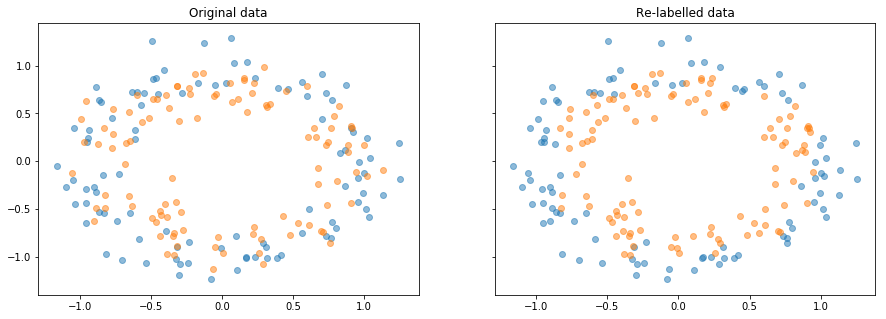

In [8]:
fig, (sub1, sub2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
sub1.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], alpha=0.5)
sub1.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], alpha=0.5)
sub1.set_title('Original data')

sub2.scatter(X_train[y_new == 0, 0], X_train[y_new == 0, 1], alpha=0.5)
sub2.scatter(X_train[y_new == 1, 0], X_train[y_new == 1, 1], alpha=0.5)
sub2.set_title('Re-labelled data')

plt.show()


It is difficult to see what exactly has changed so let's plot the changes but colour them by their class in the original data.

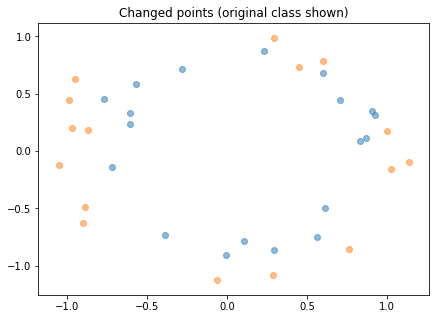

In [9]:
# Changed points:
#  -1 indicates 1 changed to 0 
#  +1 indicates 0 changed to 1
y_changed = y_train - y_new


fig, sub3 = plt.subplots(figsize=(7,5))
sub3.scatter(X_train[y_changed == -1, 0], X_train[y_changed == -1, 1], alpha=0.5)
sub3.scatter(X_train[y_changed == 1, 0], X_train[y_changed == 1, 1], alpha=0.5)
sub3.set_title('Changed points (original class shown)')

plt.show()

In the re-labelled some of the noise has been removed and the classes are therefore better seperated. It is, therefore, easier for the simple classifier to find a decision boundary that seperates the two classes. It is being guided by where the complex model thinks misclassifications are OK in order to produce an overall more accurate model. So whilst the simple model is expressive enough to create a good decision boundary it was not able to learn this boundary as well as the complex model.

A (not brilliant) analogy would be to consider two golders: one a golf pro and one an amateur. The golf pro would be much better at hitting the ball towards the fairway than the amateur as he is better able to judge the conditions of each hole, but the amateur can improve his game by looking at what the pro does rather than just his own judgement about the right shot to take. 

## Visualising the tree

Following the scikit-learn documentation you can visualise the simple tree as follows (note you will need graphviz installed).

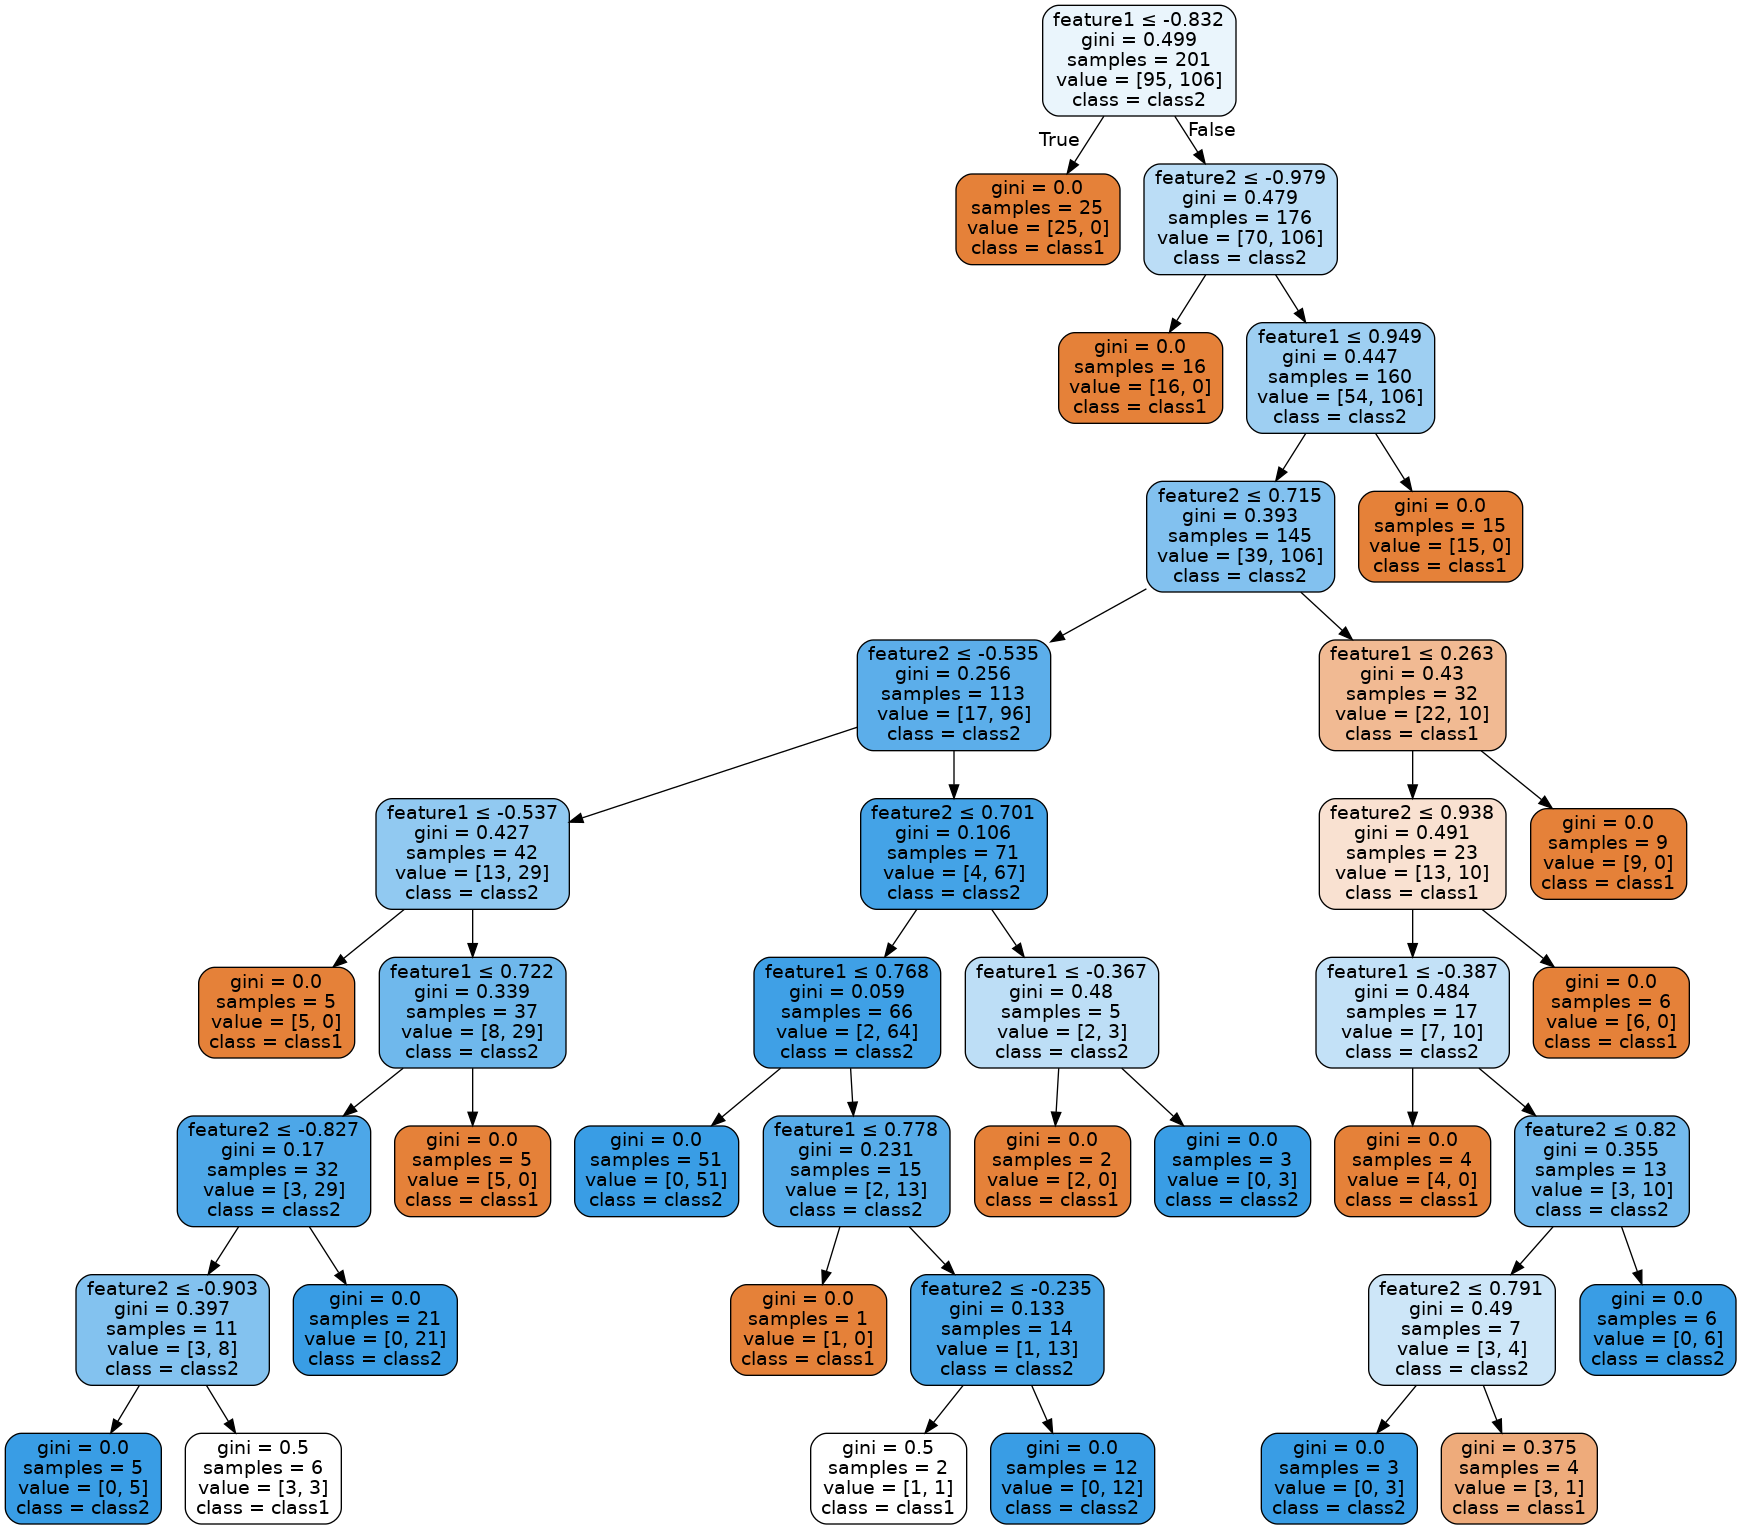

In [10]:
dot_data = export_graphviz(grid_simp2.best_estimator_, out_file=None, 
                         feature_names=["feature1", "feature2"],  
                         class_names=["class1", "class2"],  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Quite a complicated model! It is not necessarily the case that the new simple model (trained on the additional data) will be more complicated that the original simple model, more accuracy tends to make the new model more complicated but on the other hand reducing noise means that the model is less likely to overfit.

## An example where this doesn't work

This approach will not always work. To illustrate consider the example below. Here we use images of digits hand-written digits which we want to classify.

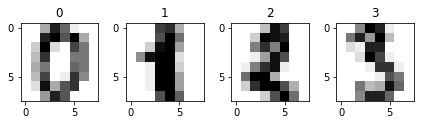

In [11]:
# Load the data
data = load_digits(n_class=10, return_X_y=True)
X_digits = data[0]
y_digits = data[1]

# Train/test split
Xd_train, Xd_test, yd_train, yd_test = train_test_split(
                                    X_digits, y_digits, test_size=0.33, random_state=40 )

# Plot some of the data
plt.figure()
for i in range(4):
    ax= plt.subplot(1,4 ,i+1)
    im=ax.imshow(X_digits[i].reshape([8,8]), cmap=plt.cm.gray_r)
    plt.title(y_digits[i])
    plt.tight_layout()
    
plt.show()

Let's repeat the process from before: first train a single decision tree on the data; then train a gradient boosted decision tree on the data; use this more complex model to re-label the training data; and finally re-train the single decision tree.

In [12]:
# Simple model trained on original data
digits_simp = DecisionTreeClassifier(random_state=40)
grid_d_simp = GridSearchCV(digits_simp, cv=3, refit=True, param_grid=params_simp)
grid_d_simp.fit(Xd_train, yd_train)
simp_f1 = f1_score(yd_test, grid_d_simp.predict(Xd_test), average='micro')

# Complex model trained on orginal data
digits_comp = XGBClassifier()
grid_d_comp = GridSearchCV(model_comp, cv=3, refit=True, param_grid=params_comp)
grid_d_comp.fit(Xd_train, yd_train)
comp_f1 = f1_score(yd_test, grid_d_comp.predict(Xd_test), average='micro')

# Simple model trained on re-labelled data
yd_new = grid_d_comp.predict(Xd_train)
digits_simp2 = DecisionTreeClassifier(random_state=40)
grid_d_simp2 = GridSearchCV(digits_simp2, cv=3, refit=True, param_grid=params_simp)
grid_d_simp2.fit(Xd_train, yd_new)
simp2_f1 = f1_score(yd_test, grid_d_simp2.predict(Xd_test), average='micro')

print "F1-score simple model (original data):", simp_f1
print "F1-score complex model (original data):", comp_f1
print "F1-score simple model (re-labelled data):", simp2_f1

F1-score simple model (original data): 0.8333333333333334
F1-score complex model (original data): 0.9528619528619529
F1-score simple model (re-labelled data): 0.8333333333333334


In this case the complex model produces an excellent classifier, but re-training the simple model on the re-labelled data does not improve its performance. Using the full approach of Domingos produces the same. There are two potential reasons for this:
1. The single decision tree is not capable of producing a functional form that seperates the digits with the desired accuracy.
2. The complex model has not been able to transfer its learning to the simple model.

The later explanation makes intuitive sense in this case. Note that the boosted tree produces a really good classifier, which means that it will hardly ever misclassify the training data. This in turn means that it will not re-label many data points. As this re-labelling is the sole method by which it can transfer its learning to the single tree you would not expect the single tree to improve.

Note, this was using the crude relabelling approach. If you were to generate additional data it could make the simple model more accurate, particularly if you used approaches to generate additional data points very close to the decision boundary (where the original simple model and the complex model are likely to disagree).

What this shows is that this approach should not be seen as a way in which to aid interpretability of more complex models (as the accuracy of the simplier model might not approach that of the more complex model), but as a method which sometimes allows simplier (and more interpretable) models to gain better accuracy, accuracy that may approach that of the more complex models in some circumstances.

## Interpreting boosted decision trees

Boosted decisions and random forests are not quite the black boxes they are sometimes presented as. Instead fitting of a single decision tree onto their outputs (which does not seem to be used often) people tend to look at **feature importance**.

To demonstrate we can output the feature importances for our complex model.

In [13]:
from xgboost import plot_importance

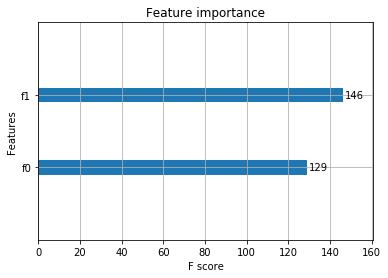

In [14]:
plot_importance(grid_comp.best_estimator_)
plt.show()

As there were only two features the graph is not very informative. These plots show which features are most important to the model overall.

Another apporach is to plot partial depency curves (implemented in scikit-learn but not xgboost) which plots out how the prediction changes when a variable changes, holding constant the contribution of the other variables (http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html). These plots only make sense if, roughly speaking, the predictions can be considered as depending on the most important variables seperately (they don't interact).

Another approach is to trace out the prediction path through the tree for any given prediction. For sci-kit learn models this has been implemented in the treeinterpreter package (https://github.com/andosa/treeinterpreter). This has not been implemented in xgboost yet but it, in effect, gives feature importance for each prediction showing the features that most influenced that particular result.